# Preparação

In [2]:
import pandas as pd
import seaborn as sns
import swifter

In [3]:
bus_trips = pd.read_pickle("bus_trips.pickle")
bus_positions = pd.read_pickle("bus_positions.pickle")
stop_list = pd.read_pickle("stop_list.pickle")

In [4]:
bus_trips

,trip_id,datetime_partida,datetime_chegada,id_veiculo,sentido,tempo_viagem
0,6339,2023-01-01 05:00:22,2023-01-01 05:55:22,C41054,I,56
1,6346,2023-01-01 05:42:45,2023-01-01 06:47:15,C41215,I,66
2,6324,2023-01-01 06:46:39,2023-01-01 07:57:09,A41282,I,72
3,6331,2023-01-01 07:04:50,2023-01-01 08:10:50,C41010,I,67
4,6335,2023-01-01 07:21:04,2023-01-01 08:22:34,C41021,I,62
...,...,...,...,...,...,...
63387,33949,2023-07-30 22:37:12,2023-07-30 23:39:42,C41385,I,63
63388,33795,2023-07-30 22:55:23,2023-07-30 23:54:53,A41016,I,60
63389,33868,2023-07-30 23:11:43,2023-07-31 00:19:13,A41457,I,69
63390,33809,2023-07-30 23:25:41,2023-07-31 00:26:41,A41125,I,62


In [5]:
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance,next_stop_index,previous_stop_index,distance_from_route,timestamp_hour
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065,70,69,0.000042,15
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657,70,69,0.000053,15
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263,70,69,0.000072,15
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515,71,70,0.000014,15
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197,71,70,0.000021,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802,67,66,0.000040,21
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445,67,66,0.000137,21
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303,68,67,0.000101,21
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688,68,67,0.000038,21


In [6]:
stop_list

,stop_id,shape_dist_traveled,sentido,relative_position,geometry
stop_sequence,,,,,
0,wcdt,0.00,I,0.000000,POINT (-43.36520 -23.00147)
1,4128O00209C0,2935.40,I,0.040796,POINT (-43.36633 -23.00904)
2,4128O00035C0,3746.88,I,0.052074,POINT (-43.36793 -23.01099)
3,4128O00036C0,4178.28,I,0.058069,POINT (-43.36461 -23.01085)
4,4128O00037C0,4710.90,I,0.065471,POINT (-43.35939 -23.01065)
...,...,...,...,...,...
137,4128O00121C0,68369.50,V,0.950191,POINT (-43.35994 -23.01039)
138,4128O00122C0,68793.55,V,0.956084,POINT (-43.36371 -23.01049)
139,4128O00055C0,69229.90,V,0.962148,POINT (-43.36601 -23.00861)


# Análise

## Validade dos dados - os ônibus estão seguindo a rota?

<Axes: ylabel='distance_from_route'>

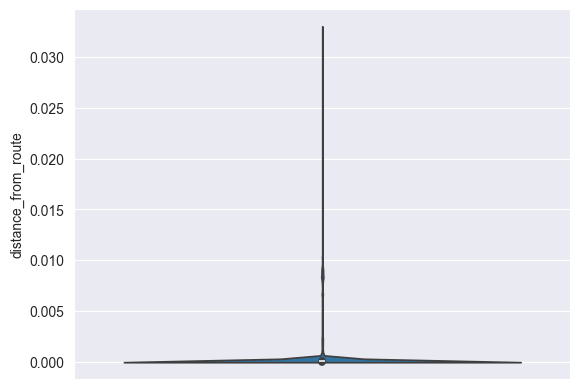

In [7]:
sns.violinplot(bus_positions['distance_from_route'])

## 2.1 - Quais horários possuem maior tempo de espera no ponto de ônibus?

In [8]:
bus_positions['timestamp_hour'] = bus_positions.timestamp_gps.dt.hour

In [9]:
traveling_buses = bus_positions[(bus_positions.next_stop_index != bus_positions.previous_stop_index) & (bus_positions.velocidade_instantanea > 0)]
traveling_buses['stop_distance'] = traveling_buses.swifter.apply(lambda x: stop_list.loc[x['next_stop_index'], 'shape_dist_traveled'] - stop_list.loc[x['previous_stop_index'], 'shape_dist_traveled'], axis=1)
traveling_buses  

Pandas Apply:   0%|          | 0/7140754 [00:00<?, ?it/s]

C:\Users\thlam\AppData\Local\Temp\ipykernel_15084\652173036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traveling_buses['stop_distance'] = traveling_buses.swifter.apply(lambda x: stop_list.loc[x['next_stop_index'], 'shape_dist_traveled'] - stop_list.loc[x['previous_stop_index'], 'shape_dist_traveled'], axis=1)


,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance,next_stop_index,previous_stop_index,distance_from_route,timestamp_hour,stop_distance
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065,70,69,0.000042,15,1137.20
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657,70,69,0.000053,15,1137.20
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263,70,69,0.000072,15,1137.20
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515,71,70,0.000014,15,534.65
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197,71,70,0.000021,15,534.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802,67,66,0.000040,21,487.88
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445,67,66,0.000137,21,487.88
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303,68,67,0.000101,21,640.61
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688,68,67,0.000038,21,640.61


In [10]:
average_speed_by_hour_and_segment = traveling_buses.groupby(['timestamp_hour', 'next_stop_index']).agg({
    'velocidade_instantanea': 'mean',
    'stop_distance': 'first'
}).reset_index()
average_speed_by_hour_and_segment

,timestamp_hour,next_stop_index,velocidade_instantanea,stop_distance
0,0,1,52.889901,2935.40
1,0,2,38.453147,811.48
2,0,3,43.359281,431.40
3,0,4,55.226387,532.62
4,0,5,54.159664,370.84
...,...,...,...,...
3379,23,137,42.392617,455.99
3380,23,138,51.643678,424.05
3381,23,139,48.941532,436.35
3382,23,140,46.512411,453.71


In [11]:
average_speed_by_hour_and_segment['time_to_serve'] = average_speed_by_hour_and_segment['stop_distance'] / (average_speed_by_hour_and_segment['velocidade_instantanea'] / 3.6)
average_speed_by_hour_and_segment

,timestamp_hour,next_stop_index,velocidade_instantanea,stop_distance,time_to_serve
0,0,1,52.889901,2935.40,199.800716
1,0,2,38.453147,811.48,75.971104
2,0,3,43.359281,431.40,35.817937
3,0,4,55.226387,532.62,34.719490
4,0,5,54.159664,370.84,24.649784
...,...,...,...,...,...
3379,23,137,42.392617,455.99,38.722874
3380,23,138,51.643678,424.05,29.559862
3381,23,139,48.941532,436.35,32.096666
3382,23,140,46.512411,453.71,35.116562


In [12]:
stop_serve_time = average_speed_by_hour_and_segment.set_index(["timestamp_hour", "next_stop_index"])['time_to_serve']
stop_serve_time.sort_index(inplace=True)
stop_serve_time

timestamp_hour  next_stop_index
0               1                  199.800716
                2                   75.971104
                3                   35.817937
                4                   34.719490
                5                   24.649784
                                      ...    
23              137                 38.722874
                138                 29.559862
                139                 32.096666
                140                 35.116562
                141                149.979959
Name: time_to_serve, Length: 3384, dtype: float64

In [13]:
from tqdm import tqdm

days = bus_trips.datetime_chegada.dt.day_of_year.unique()

forward_stops = stop_list[stop_list['sentido'] == 'I'].index
backward_stops = stop_list[stop_list['sentido'] == 'V'].index

day_visits = {}
for day in tqdm(days, total=len(days)):
    trips = bus_trips[(bus_trips.datetime_chegada.dt.day_of_year == day)]
    stop_visit_times = {stop: [] for stop in stop_list.index}
    for index, trip in trips.iterrows():
        current_time = trip['datetime_partida']
        
        if trip['sentido'] == 'I':
            stops = forward_stops
        else:
            stops = backward_stops
        
        for stop in stops:
            stop_visit_times[stop].append(current_time)
            
            hour = current_time.hour
            # If this hour and stop are not in the stop_serve_time table, then the bus skips this stop
            if (hour, stop) not in stop_serve_time.index:
                continue
             
            current_time += (stop_serve_time[hour, stop] if stop > 0 else 0) * pd.Timedelta(seconds=1)
    day_visits[day] = stop_visit_times

100%|██████████| 212/212 [02:02<00:00,  1.74it/s]


In [40]:
day_dataframe = pd.DataFrame.from_dict(day_visits, orient='index')
day_dataframe.reset_index(inplace=True, names='day_of_year')
day_dataframe = day_dataframe.melt(
    id_vars=['day_of_year'],
    var_name='stop number',
    value_name='visit_times'
)
day_dataframe = day_dataframe.explode('visit_times', ignore_index=True)
day_dataframe = pd.merge(day_dataframe, stop_list['sentido'], left_on='stop number', right_index=True, how='left')
day_dataframe.sort_values(['day_of_year', 'stop number', 'visit_times'], inplace=True)
day_dataframe

,day_of_year,stop number,visit_times,sentido
0,1,0,2023-01-01 05:00:22.000000000,I
1,1,0,2023-01-01 05:42:45.000000000,I
2,1,0,2023-01-01 06:46:39.000000000,I
3,1,0,2023-01-01 07:04:50.000000000,I
4,1,0,2023-01-01 07:21:04.000000000,I
...,...,...,...,...
4374491,212,137,2023-07-31 00:36:46.840299586,V
4406000,212,138,2023-07-31 00:37:17.025044463,V
4437509,212,139,2023-07-31 00:37:44.447964289,V
4469018,212,140,2023-07-31 00:38:15.009229395,V


In [41]:
day_dataframe = day_dataframe[(7 <= day_dataframe['visit_times'].dt.hour) & (day_dataframe['visit_times'].dt.hour <= 20)]

In [42]:
shifted = day_dataframe.groupby(['day_of_year', 'sentido', 'stop number'])['visit_times'].shift(1)
day_dataframe['time_since_last_visit'] = day_dataframe['visit_times'] - shifted
day_dataframe

C:\Users\thlam\AppData\Local\Temp\ipykernel_15084\1050141554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dataframe['time_since_last_visit'] = day_dataframe['visit_times'] - shifted


,day_of_year,stop number,visit_times,sentido,time_since_last_visit
3,1,0,2023-01-01 07:04:50.000000000,I,NaT
4,1,0,2023-01-01 07:21:04.000000000,I,0 days 00:16:14
5,1,0,2023-01-01 08:02:25.000000000,I,0 days 00:41:21
6,1,0,2023-01-01 09:05:06.000000000,I,0 days 01:02:41
7,1,0,2023-01-01 09:11:43.000000000,I,0 days 00:06:37
...,...,...,...,...,...
4500518,211,141,2023-07-30 20:12:00.688827274,V,0 days 00:10:30.072130982
4500519,211,141,2023-07-30 20:25:44.956084856,V,0 days 00:13:44.267257582
4500520,211,141,2023-07-30 20:37:45.549811711,V,0 days 00:12:00.593726855
4500521,211,141,2023-07-30 20:49:59.254348975,V,0 days 00:12:13.704537264


In [43]:
day_dataframe['wait time (s)'] = day_dataframe['time_since_last_visit'].dt.seconds
wait_time_mean = day_dataframe['wait time (s)'].mean()
day_dataframe['wait difference from avg (s)'] = day_dataframe['wait time (s)'] - wait_time_mean
day_dataframe

C:\Users\thlam\AppData\Local\Temp\ipykernel_15084\590784402.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dataframe['wait time (s)'] = day_dataframe['time_since_last_visit'].dt.seconds
C:\Users\thlam\AppData\Local\Temp\ipykernel_15084\590784402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dataframe['wait difference from avg (s)'] = day_dataframe['wait time (s)'] - wait_time_mean


,day_of_year,stop number,visit_times,sentido,time_since_last_visit,wait time (s),wait difference from avg (s)
3,1,0,2023-01-01 07:04:50.000000000,I,NaT,NaN,NaN
4,1,0,2023-01-01 07:21:04.000000000,I,0 days 00:16:14,974.0,505.681131
5,1,0,2023-01-01 08:02:25.000000000,I,0 days 00:41:21,2481.0,2012.681131
6,1,0,2023-01-01 09:05:06.000000000,I,0 days 01:02:41,3761.0,3292.681131
7,1,0,2023-01-01 09:11:43.000000000,I,0 days 00:06:37,397.0,-71.318869
...,...,...,...,...,...,...,...
4500518,211,141,2023-07-30 20:12:00.688827274,V,0 days 00:10:30.072130982,630.0,161.681131
4500519,211,141,2023-07-30 20:25:44.956084856,V,0 days 00:13:44.267257582,824.0,355.681131
4500520,211,141,2023-07-30 20:37:45.549811711,V,0 days 00:12:00.593726855,720.0,251.681131
4500521,211,141,2023-07-30 20:49:59.254348975,V,0 days 00:12:13.704537264,733.0,264.681131


In [44]:
day_dataframe['hour'] = day_dataframe['visit_times'].dt.hour
average_hourly_wait = day_dataframe.groupby(['stop number', 'hour']).agg({
    'wait time (s)': 'mean', 
    'wait difference from avg (s)': 'mean',
    'sentido': 'first'
}).reset_index()
average_hourly_wait

C:\Users\thlam\AppData\Local\Temp\ipykernel_15084\4206033569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dataframe['hour'] = day_dataframe['visit_times'].dt.hour


,stop number,hour,wait time (s),wait difference from avg (s),sentido
0,0,7,381.571429,-86.747440,I
1,0,8,404.047824,-64.271045,I
2,0,9,491.268714,22.949845,I
3,0,10,429.396571,-38.922297,I
4,0,11,443.986301,-24.332567,I
...,...,...,...,...,...
1983,141,16,415.217822,-53.101047,V
1984,141,17,460.754551,-7.564318,V
1985,141,18,493.727090,25.408221,V
1986,141,19,499.437176,31.118307,V


In [45]:
average_wait_time_by_hour = average_hourly_wait.groupby(['sentido', 'hour']).agg({
    'wait time (s)': 'mean', 
    'wait difference from avg (s)': 'mean'
}).reset_index()
average_wait_time_by_hour['wait time (m)'] = average_wait_time_by_hour['wait time (s)'] / 60
average_wait_time_by_hour['wait difference from avg (s)'] = average_wait_time_by_hour['wait difference from avg (s)'] / 60
average_wait_time_by_hour

,sentido,hour,wait time (s),wait difference from avg (s),wait time (m)
0,I,7,372.650565,-1.594472,6.210843
1,I,8,426.366138,-0.699212,7.106102
2,I,9,440.419017,-0.464998,7.340317
3,I,10,462.856661,-0.091037,7.714278
4,I,11,432.687416,-0.593858,7.211457
5,I,12,473.486118,0.086121,7.891435
6,I,13,523.495176,0.919605,8.724920
7,I,14,528.768657,1.007496,8.812811
8,I,15,534.848470,1.108827,8.914141
9,I,16,514.228073,0.765153,8.570468


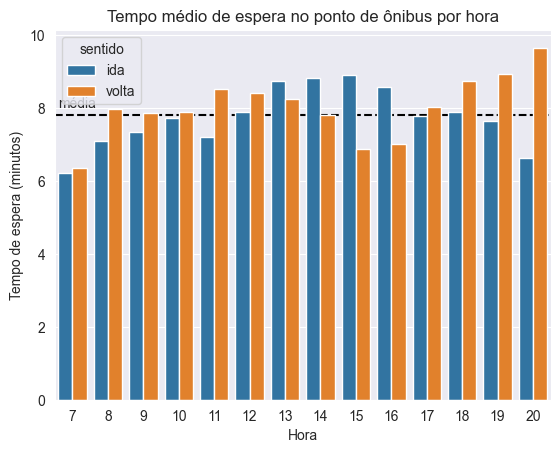

In [46]:
g = sns.barplot(average_wait_time_by_hour, x='hour', hue='sentido', y='wait time (m)')
line = g.axhline(y=wait_time_mean/60, color='black', linestyle='--', zorder=-1)
g.text(x=-0.4, y=wait_time_mean/60 + 0.2, s="média") 
g.set(title="Tempo médio de espera no ponto de ônibus por hora", xlabel="Hora", ylabel="Tempo de espera (minutos)")
sns.move_legend(g, 'upper left', labels=['ida', 'volta'])

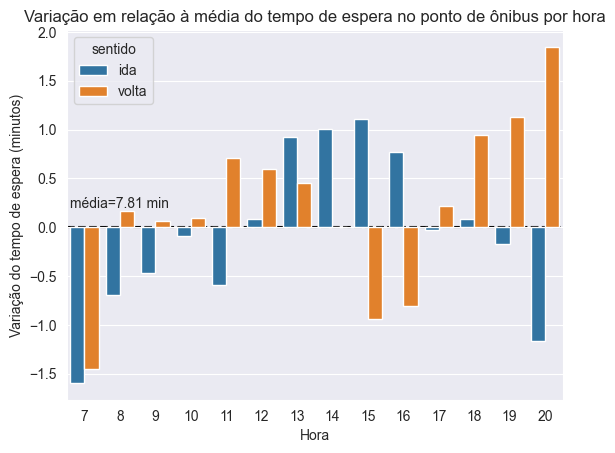

In [47]:
g = sns.barplot(average_wait_time_by_hour, x='hour', hue='sentido', y='wait difference from avg (s)')
g.axhline(y=0, color='black', linestyle='--', zorder=-1)
g.text(x=-0.4, y=0.2, s=f"média={wait_time_mean/60:.2f} min") 
g.set(title="Variação em relação à média do tempo de espera no ponto de ônibus por hora", xlabel="Hora", ylabel="Variação do tempo de espera (minutos)")
sns.move_legend(g, 'upper left', labels=['ida', 'volta'])

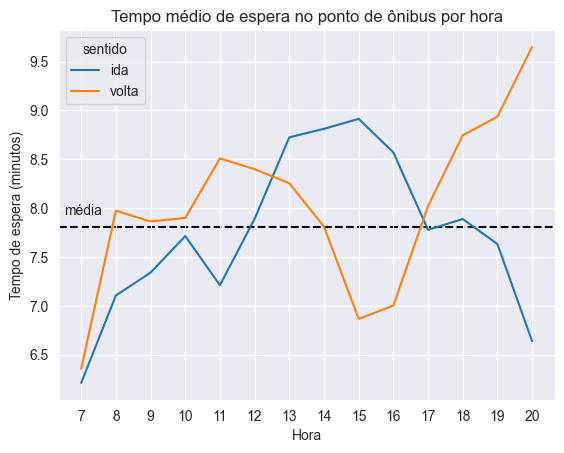

In [48]:
g = sns.lineplot(average_wait_time_by_hour, x='hour', hue='sentido', y='wait time (m)')
g.set(title="Tempo médio de espera no ponto de ônibus por hora", xlabel="Hora", ylabel="Tempo de espera (minutos)", xticks=average_wait_time_by_hour.hour.unique())
g.axhline(y=wait_time_mean/60, color='black', linestyle='--', zorder=-1)
g.text(x=6.5, y=wait_time_mean/60 + 0.13, s="média") 
sns.move_legend(g, 'upper left', labels=['ida', 'volta'])

In [49]:
grouped_df = day_dataframe.groupby(['day_of_year', 'sentido', 'hour', 'stop number']).agg({'wait time (s)': 'mean', 'wait difference from avg (s)': 'mean'}).reset_index()

grouped_df

,day_of_year,sentido,hour,stop number,wait time (s),wait difference from avg (s)
0,1,I,7,0,974.000000,505.681131
1,1,I,7,1,974.000000,505.681131
2,1,I,7,2,974.000000,505.681131
3,1,I,7,3,974.000000,505.681131
4,1,I,7,4,974.000000,505.681131
...,...,...,...,...,...,...
417131,211,V,20,137,699.800000,231.481131
417132,211,V,20,138,698.800000,230.481131
417133,211,V,20,139,750.833333,282.514464
417134,211,V,20,140,750.333333,282.014464


## 2.2	Alguns motoristas dirigem significativamente mais rápido ou devagar que outros?

In [50]:
bus_positions_normal_hours = bus_positions[(7 <= bus_positions['timestamp_gps'].dt.hour) & (bus_positions['timestamp_gps'].dt.hour <= 20)]
daily_hourly_speed_average = bus_positions_normal_hours.groupby([bus_positions_normal_hours.timestamp_gps.dt.day_of_week, bus_positions_normal_hours.timestamp_gps.dt.hour])['velocidade_instantanea'].agg(velocidade_média_momento='mean')
daily_hourly_speed_average

velocidade_média_momento
timestamp_gps timestamp_gps                          
0             7                             23.428644
              8                             21.618964
              9                             20.917500
              10                            22.163380
              11                            22.224347
...                                               ...
6             16                            23.841768
              17                            22.404065
              18                            22.282446
              19                            24.297047
              20                            26.761779

[98 rows x 1 columns]

In [51]:
trip_average_speed = bus_positions_normal_hours.groupby(['trip_id'])['velocidade_instantanea'].agg(velocidade_média='mean')
trip_average_speed

,velocidade_média
trip_id,
0.0,29.503704
1.0,31.247934
2.0,25.210884
3.0,25.298507
4.0,31.742574
...,...
63387.0,23.403727
63388.0,36.392857
63389.0,24.478261


In [52]:
trips_with_average_speed = pd.merge(bus_trips, trip_average_speed, left_on='trip_id', right_index=True)
trips_with_average_speed

,trip_id,datetime_partida,datetime_chegada,id_veiculo,sentido,tempo_viagem,velocidade_média
2,6324,2023-01-01 06:46:39,2023-01-01 07:57:09,A41282,I,72,26.707965
3,6331,2023-01-01 07:04:50,2023-01-01 08:10:50,C41010,I,67,29.338346
4,6335,2023-01-01 07:21:04,2023-01-01 08:22:34,C41021,I,62,30.685484
5,6354,2023-01-01 08:02:25,2023-01-01 09:06:25,C41372,I,65,29.400000
6,6360,2023-01-01 09:05:06,2023-01-01 10:24:33,C41396,I,80,26.477419
...,...,...,...,...,...,...,...
63375,33848,2023-07-30 20:15:23,2023-07-30 21:23:23,A41447,I,69,30.055556
63376,33801,2023-07-30 20:24:17,2023-07-30 21:29:17,A41030,I,66,34.472222
63377,33860,2023-07-30 20:44:16,2023-07-30 21:55:46,A41455,I,72,31.375000
63378,33881,2023-07-30 20:44:57,2023-07-30 21:55:27,A41465,I,72,40.870968


In [53]:
trips_with_average_speed['datetime_meio'] = trips_with_average_speed['datetime_partida'] + (trips_with_average_speed['datetime_chegada'] - trips_with_average_speed['datetime_partida']) / 2
trips_with_average_speed

,trip_id,datetime_partida,datetime_chegada,id_veiculo,sentido,tempo_viagem,velocidade_média,datetime_meio
2,6324,2023-01-01 06:46:39,2023-01-01 07:57:09,A41282,I,72,26.707965,2023-01-01 07:21:54.000
3,6331,2023-01-01 07:04:50,2023-01-01 08:10:50,C41010,I,67,29.338346,2023-01-01 07:37:50.000
4,6335,2023-01-01 07:21:04,2023-01-01 08:22:34,C41021,I,62,30.685484,2023-01-01 07:51:49.000
5,6354,2023-01-01 08:02:25,2023-01-01 09:06:25,C41372,I,65,29.400000,2023-01-01 08:34:25.000
6,6360,2023-01-01 09:05:06,2023-01-01 10:24:33,C41396,I,80,26.477419,2023-01-01 09:44:49.500
...,...,...,...,...,...,...,...,...
63375,33848,2023-07-30 20:15:23,2023-07-30 21:23:23,A41447,I,69,30.055556,2023-07-30 20:49:23.000
63376,33801,2023-07-30 20:24:17,2023-07-30 21:29:17,A41030,I,66,34.472222,2023-07-30 20:56:47.000
63377,33860,2023-07-30 20:44:16,2023-07-30 21:55:46,A41455,I,72,31.375000,2023-07-30 21:20:01.000
63378,33881,2023-07-30 20:44:57,2023-07-30 21:55:27,A41465,I,72,40.870968,2023-07-30 21:20:12.000


In [54]:
trips_with_average_speed['dia'] = trips_with_average_speed['datetime_meio'].dt.day_of_week
trips_with_average_speed['hora'] = trips_with_average_speed['datetime_meio'].dt.hour
trips_with_average_speed

,trip_id,datetime_partida,datetime_chegada,id_veiculo,sentido,tempo_viagem,velocidade_média,datetime_meio,dia,hora
2,6324,2023-01-01 06:46:39,2023-01-01 07:57:09,A41282,I,72,26.707965,2023-01-01 07:21:54.000,6,7
3,6331,2023-01-01 07:04:50,2023-01-01 08:10:50,C41010,I,67,29.338346,2023-01-01 07:37:50.000,6,7
4,6335,2023-01-01 07:21:04,2023-01-01 08:22:34,C41021,I,62,30.685484,2023-01-01 07:51:49.000,6,7
5,6354,2023-01-01 08:02:25,2023-01-01 09:06:25,C41372,I,65,29.400000,2023-01-01 08:34:25.000,6,8
6,6360,2023-01-01 09:05:06,2023-01-01 10:24:33,C41396,I,80,26.477419,2023-01-01 09:44:49.500,6,9
...,...,...,...,...,...,...,...,...,...,...
63375,33848,2023-07-30 20:15:23,2023-07-30 21:23:23,A41447,I,69,30.055556,2023-07-30 20:49:23.000,6,20
63376,33801,2023-07-30 20:24:17,2023-07-30 21:29:17,A41030,I,66,34.472222,2023-07-30 20:56:47.000,6,20
63377,33860,2023-07-30 20:44:16,2023-07-30 21:55:46,A41455,I,72,31.375000,2023-07-30 21:20:01.000,6,21
63378,33881,2023-07-30 20:44:57,2023-07-30 21:55:27,A41465,I,72,40.870968,2023-07-30 21:20:12.000,6,21


In [55]:
trip_speed_comparison = pd.merge(trips_with_average_speed, daily_hourly_speed_average, left_on=['dia', 'hora'], right_index=True)[['trip_id', 'datetime_partida', 'velocidade_média', 'velocidade_média_momento']]
trip_speed_comparison

,trip_id,datetime_partida,velocidade_média,velocidade_média_momento
2,6324,2023-01-01 06:46:39,26.707965,29.219220
3,6331,2023-01-01 07:04:50,29.338346,29.219220
4,6335,2023-01-01 07:21:04,30.685484,29.219220
1783,8964,2023-01-08 06:33:12,24.171429,29.219220
1784,9069,2023-01-08 06:35:42,40.652174,29.219220
...,...,...,...,...
63192,55666,2023-07-29 20:03:11,21.745614,25.542059
63193,55479,2023-07-29 20:08:15,27.355769,25.542059
63194,55687,2023-07-29 20:16:51,30.459770,25.542059
63195,55560,2023-07-29 20:21:40,33.688312,25.542059


In [56]:
trip_speed_comparison['diferença de velocidade'] = trip_speed_comparison['velocidade_média'] - trip_speed_comparison['velocidade_média_momento']
trip_speed_comparison

,trip_id,datetime_partida,velocidade_média,velocidade_média_momento,diferença de velocidade
2,6324,2023-01-01 06:46:39,26.707965,29.219220,-2.511256
3,6331,2023-01-01 07:04:50,29.338346,29.219220,0.119126
4,6335,2023-01-01 07:21:04,30.685484,29.219220,1.466264
1783,8964,2023-01-08 06:33:12,24.171429,29.219220,-5.047792
1784,9069,2023-01-08 06:35:42,40.652174,29.219220,11.432954
...,...,...,...,...,...
63192,55666,2023-07-29 20:03:11,21.745614,25.542059,-3.796445
63193,55479,2023-07-29 20:08:15,27.355769,25.542059,1.813710
63194,55687,2023-07-29 20:16:51,30.459770,25.542059,4.917711
63195,55560,2023-07-29 20:21:40,33.688312,25.542059,8.146253


[Text(0.5, 1.0, 'Distribuição de viagens '),
 Text(0.5, 0, 'Diferença de velocidade (km/h)'),
 Text(0, 0.5, 'Número de viagens')]

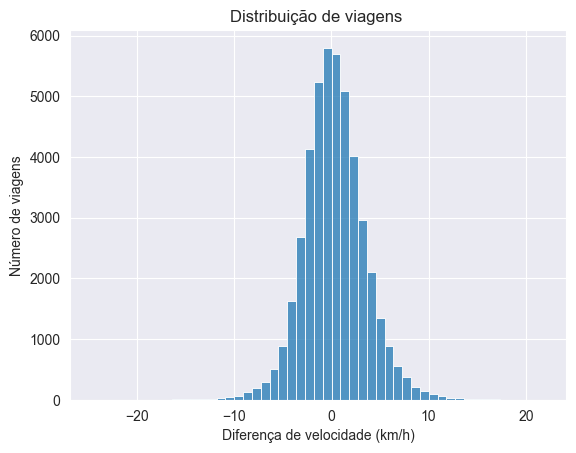

In [57]:
g = sns.histplot(trip_speed_comparison['diferença de velocidade'], bins=51)
g.set(title="Distribuição de viagens ", xlabel="Diferença de velocidade (km/h)", ylabel="Número de viagens")

[Text(0.5, 1.0, 'Distribuição da diferença de velocidade em relação à média do momento'),
 Text(0, 0.5, 'Diferença de velocidade (km/h)')]

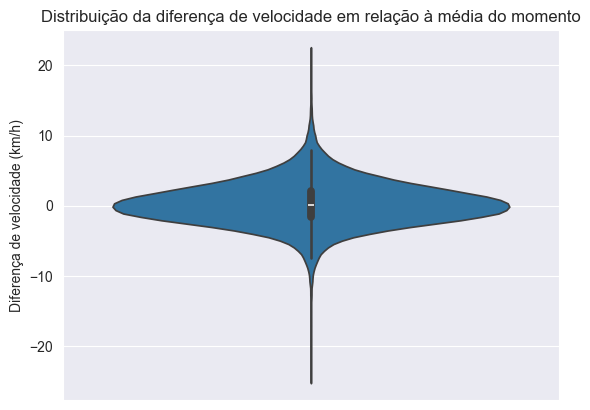

In [58]:
g = sns.violinplot(trip_speed_comparison['diferença de velocidade'])
g.set(title="Distribuição da diferença de velocidade em relação à média do momento", ylabel="Diferença de velocidade (km/h)")

[Text(0.5, 1.0, 'Distribuição da diferença de velocidade em relação à média do momento'),
 Text(0, 0.5, 'Diferença de velocidade (km/h)')]

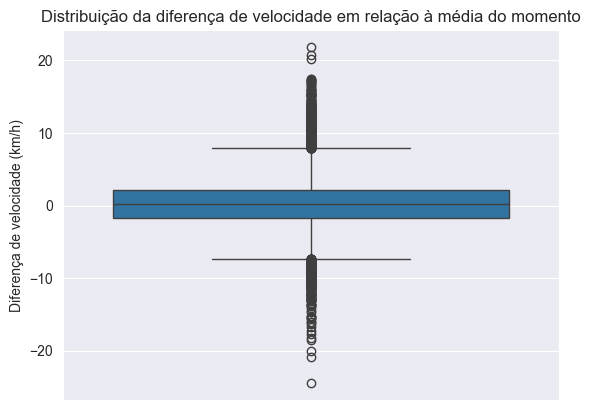

In [59]:
g = sns.boxplot(trip_speed_comparison['diferença de velocidade'])
g.set(title="Distribuição da diferença de velocidade em relação à média do momento", ylabel="Diferença de velocidade (km/h)")

In [60]:
trip_speed_comparison['diferença de velocidade'].describe()

count    45350.000000
mean         0.326205
std          3.182842
min        -24.499546
25%         -1.654465
50%          0.183007
75%          2.166395
max         21.832678
Name: diferença de velocidade, dtype: float64